In [1]:
import numpy as np  
import matplotlib.pyplot as plt
% matplotlib inline

### Utility functions ###

Initialize graph with parameters for Q and S (D=Q+S)

In [2]:
def init_graph(L, N):
    Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    Q = Q.reshape((L,N))
    S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    S = S.reshape((L,N))
    return {"Q":Q, "S":S}

Given a LxN graph, pick a pair of paths that differ only by ith node fo layer *layer*

In [3]:
def path_pair(layer, i, L, N):
    path_a = np.random.choice(N, L)
    path_b = path_a.copy()
    path_a[layer] = i
    path_b[layer] = (i+1)%N
    
    return path_a, path_b

Draw P random delays for each node in A according to their distributions (A=graph["Q"] or A=graph["S"])

In [4]:
sigma=0.2
def draw_delays(A, P, distr):
    L = A.shape[0]
    N = A.shape[1]
    draw = []
    for node in A.reshape(-1,1):
        if distr == "exp":
            draw.append(np.random.exponential(node, size=P))
        if distr == "gaussian":
            draw.append(node + np.sqrt(node*sigma)*np.random.randn(P))
    return np.array(draw).reshape(L,N,P)

Approximate the deviations for all the nodes of a layer

In [38]:
def approximate_deviations(layer, graph, distr, P):
    L = graph["Q"].shape[0]
    N = graph["Q"].shape[1]
    coefs = np.arange(1,N+1)[::-1]
            
    deltas = np.zeros(N)
    delays_Q = draw_delays(graph["Q"], P, distr["Q"])
    delays_S = draw_delays(graph["S"], P, distr["S"])
    D = delays_Q + delays_S
    
    for node in range(N):
        path_A, path_B = path_pair(layer, node, L, N)
        delay_A = D[np.arange(L), path_A].sum(axis=0).mean()
        delay_B = D[np.arange(L), path_B].sum(axis=0).mean()
        deltas[node] = delay_A-delay_B
            
    deviations = np.zeros(N)
    for i in range(N):
        deviations[i] += np.sum(deltas*coefs)/(N-1)
        coefs = np.roll(coefs, 1)
    return deviations

Returns the true and approximated deviations of a given layer

In [51]:
def simulate_layer(g, layer, P, distr):
    approx_devs = approximate_deviations(layer, g, distr, P)
    #true_devs = g["Q"][layer,:]+g["S"][layer,:] - np.mean(g["Q"][layer,:]+g["S"][layer,:])

    true_devs = []
    N = g["Q"].shape[1]
    layer_sum = np.sum(g["Q"][layer,:]+g["S"][layer,:])
    for node in range(N):
        node_delay = g["Q"][layer,node]+g["S"][layer,node]
        node_dev = node_delay - (layer_sum - node_delay)/(N-1)
        true_devs.append(node_dev)
    return approx_devs, true_devs

Plot approximated deviations against true deviations

In [52]:
def plot_approx(approx_devs, true_devs):
    plt.scatter(range(N), (N/(N-1))*approx_devs, label="approx")
    plt.scatter(range(N), (N/(N-1))*true_devs, label="true")
    plt.legend(loc="best")


## Performance Monitoring: 2 nodes go wild ###

Generate a graph with random distribution means

In [107]:
N = 5
L = 5
graph = init_graph(L, N)
graph["Q"][1:]*=50
graph["Q"][1:]+=50
graph["Q"][0] +=5

graph["S"][1:]*=50
graph["S"][1:]+=50
graph["S"][0] +=5

graph

{'Q': array([[  5.75870844,   5.65462111,   5.87724562,   5.30221134,
           5.36157128],
        [ 80.26527615,  94.59506684,  99.9855415 ,  67.59222285,
          51.40919819],
        [ 52.97704182,  88.44731679,  60.84696794,  82.50389204,
          98.41200522],
        [ 61.6251374 ,  75.37280301,  72.87156303,  90.62008444,
          95.36265653],
        [ 81.78434567,  90.01455105,  70.56391265,  91.05344968,
          72.61733507]]),
 'S': array([[  5.427571  ,   5.48962335,   5.67355239,   5.90791208,
           5.33486206],
        [ 76.5079598 ,  52.34503471,  58.70234737,  89.49221113,
          70.13221773],
        [ 70.33537007,  78.79457083,  99.03610902,  69.92223706,
          95.73740262],
        [ 75.98364083,  52.92043338,  88.16723203,  57.03064162,
          63.59899276],
        [ 83.27746029,  69.76166372,  86.60741194,  55.25885261,
          78.33955177]])}

Monitor the layer for 500 timesteps, and after timestep 100, gradually increase service time for node 0, and at time 350 gradually increase for node 1

In [108]:

P=250
approx, truth = [], []
distr ={"Q":"exp", "S":"exp"}
for o in range(501):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["S"][0][0] += np.random.rand()*0.01
            if o > 350:
                graph["S"][0][1] += np.random.rand()*0.01
    a, t = simulate_layer(graph, layer=0, P=P, distr=distr)
    approx.append(a)
    truth.append(t)
graph

{'Q': array([[  5.75870844,   5.65462111,   5.87724562,   5.30221134,
           5.36157128],
        [ 80.26527615,  94.59506684,  99.9855415 ,  67.59222285,
          51.40919819],
        [ 52.97704182,  88.44731679,  60.84696794,  82.50389204,
          98.41200522],
        [ 61.6251374 ,  75.37280301,  72.87156303,  90.62008444,
          95.36265653],
        [ 81.78434567,  90.01455105,  70.56391265,  91.05344968,
          72.61733507]]),
 'S': array([[ 55.0680435 ,  24.30431133,   5.67355239,   5.90791208,
           5.33486206],
        [ 76.5079598 ,  52.34503471,  58.70234737,  89.49221113,
          70.13221773],
        [ 70.33537007,  78.79457083,  99.03610902,  69.92223706,
          95.73740262],
        [ 75.98364083,  52.92043338,  88.16723203,  57.03064162,
          63.59899276],
        [ 83.27746029,  69.76166372,  86.60741194,  55.25885261,
          78.33955177]])}

Plot the results

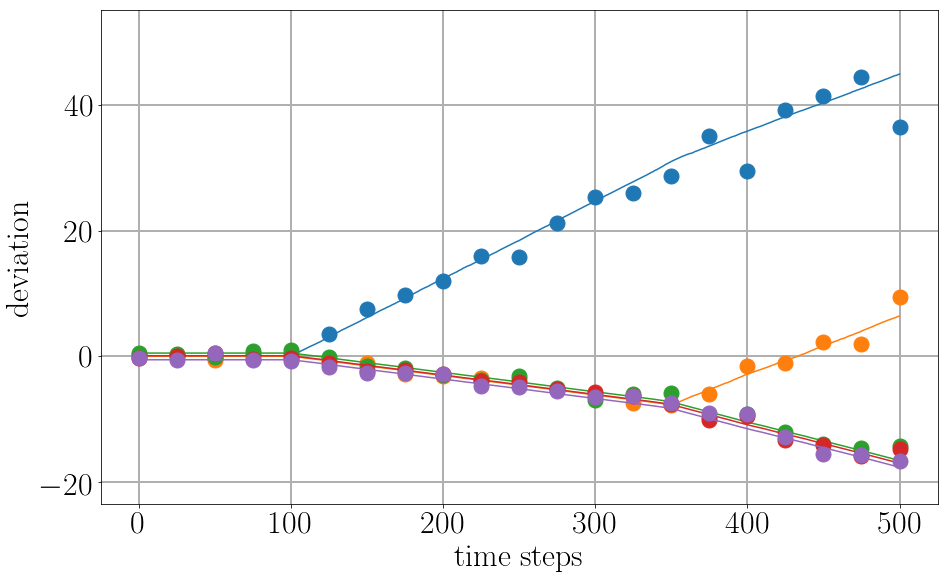

In [109]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in truth ]
    y = [z[n] for z in approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Performance Monitoring and Random Walk : everything is moving in EVERY LAYER - not only layer 0 ###

Generate a graph with random distribution means

In [110]:
N = 5
L = 5
graph = init_graph(L, N)
graph["Q"][1:]*=50
graph["Q"][1:]+=50
graph["Q"][0] +=5

graph["S"][1:]*=50
graph["S"][1:]+=50
graph["S"][0] +=5

graph

{'Q': array([[  5.32130222,   5.56872841,   5.48009337,   5.40301718,   5.491574  ],
        [ 64.51686551,  89.63411714,  90.69232677,  65.65358533,  56.9654914 ],
        [ 86.20494887,  82.63187954,  70.45087931,  95.25270747,
          77.21374611],
        [ 83.7939995 ,  50.45447623,  60.5761961 ,  86.05738742,
          53.66655468],
        [ 54.39220127,  90.29048742,  82.76001309,  59.00786124,  73.3429993 ]]),
 'S': array([[  5.53368707,   5.32139644,   5.91067545,   5.50288162,
           5.84100533],
        [ 67.42625807,  74.51497345,  94.74728423,  99.03155897,  95.998408  ],
        [ 77.6154224 ,  87.66413143,  88.72076879,  54.30171824,
          66.96552284],
        [ 91.07963214,  92.84775913,  61.88706271,  74.4073779 ,
          95.36293319],
        [ 77.89700224,  81.94973701,  69.64251995,  91.05902002,
          85.02477905]])}

Monitor the layer for 502 timesteps, and after timestep 100, turn on the random walk for every node of the graph

In [111]:

P=250
approx, truth = [], []
distr ={"Q":"exp", "S":"exp"}
for o in range(502):
    for layer in range(L):
        for node in range(N):
            if o > 100:
                graph["S"][layer][node] += np.random.rand()-0.5
                graph["S"][layer][node] = abs(graph["S"][layer][node])
    a, t = simulate_layer(graph, layer=0, P=P, distr=distr)
    approx.append(a)
    truth.append(t)
graph

{'Q': array([[  5.32130222,   5.56872841,   5.48009337,   5.40301718,   5.491574  ],
        [ 64.51686551,  89.63411714,  90.69232677,  65.65358533,  56.9654914 ],
        [ 86.20494887,  82.63187954,  70.45087931,  95.25270747,
          77.21374611],
        [ 83.7939995 ,  50.45447623,  60.5761961 ,  86.05738742,
          53.66655468],
        [ 54.39220127,  90.29048742,  82.76001309,  59.00786124,  73.3429993 ]]),
 'S': array([[  1.26784627,   5.59753987,  13.40223391,  10.3837319 ,
           9.13793934],
        [ 68.98241291,  70.14651429,  91.92329927,  97.60510742,
          93.91035514],
        [ 81.58284517,  79.70348969,  92.83355638,  52.45494843,
          69.76198271],
        [ 85.64394409,  98.31182343,  61.34607449,  76.44132845,
          87.42966358],
        [ 74.08839774,  84.90186141,  73.41266324,  89.62928585,
          77.98272814]])}

Plot the results

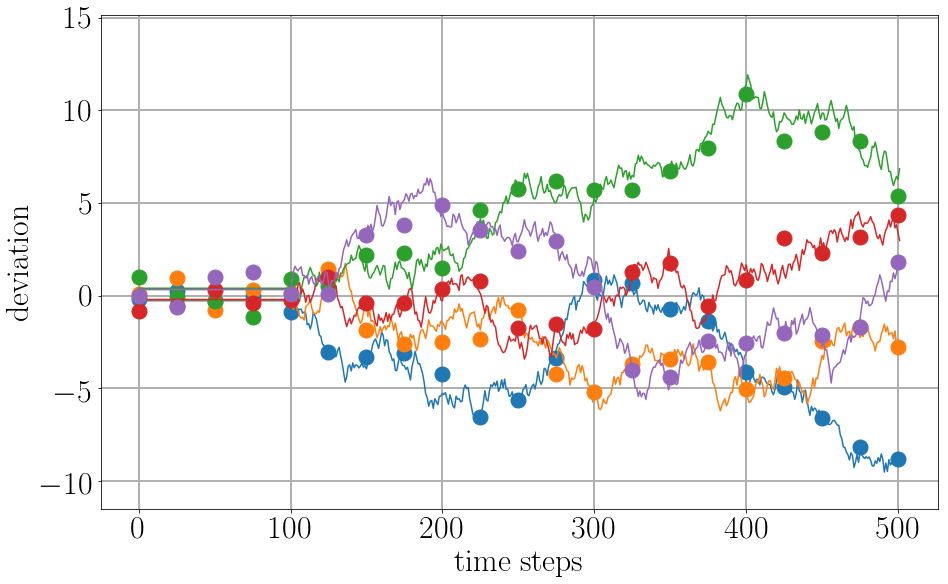

In [112]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"deviation",fontsize=32)
ax.set_xlabel(r"time steps",fontsize=32)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for n in range(N):
    x = [y[n] for y in truth ]
    y = [z[n] for z in approx ]
    plt.plot(x, label="$\widehat{\delta'}$", color=colors[n])
    plt.plot(y, label="$\delta'$", marker='o', markevery=25, markersize=15, linewidth=0)

plt.grid(linewidth=2)

### Sensitivity, Error and Sample Size ###

Compute and return the absolute difference bewteen true and approximated delays

In [113]:
def abs_diff_samples(graph, P, distr):
    L = graph["Q"].shape[0]
    diff = np.array([])
    for layer in range(L):
        a, t = simulate_layer(graph, layer=layer, P=P, distr=distr)
        diff = np.concatenate((diff, np.abs(a-t)))
    return diff

In [114]:
N = 10
L = 10
distr = {"Q":"exp", "S":"gaussian"}
diffs = {}
graph = init_graph(L,N)
graph["Q"] *= 100
graph["S"] *= 100

for p in [100, 250, 1000, 5000, 50000]:
    diffs[p] = abs_diff_samples(graph, p, distr)

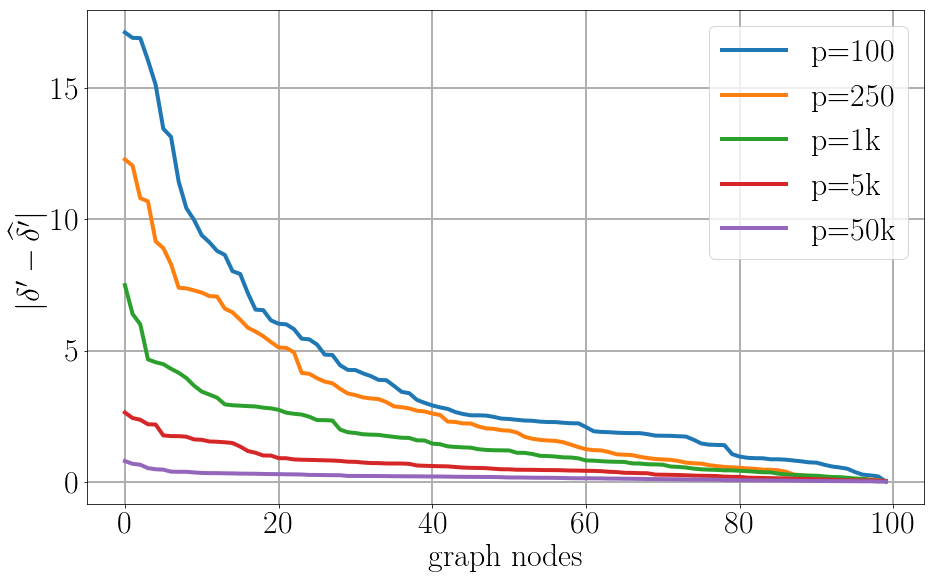

In [115]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$|\delta' - \widehat{\delta'}|$",fontsize=32)
ax.set_xlabel(r"graph nodes",fontsize=32)
#ax.set_title(r"normal distribution",fontsize=32)


for d in sorted(diffs):
    label = "p=" + str(d)
    if d > 500:
        label = "p=" +str(int(d/1000))+"k"        
    plt.plot(sorted(diffs[d], reverse=True), label=label, linewidth=4)
plt.legend(loc="best")
plt.grid(linewidth=2)

### Work in progress : Layer scale approximation ###

In [ ]:
N = 11
L = 21
sigma=0.5
graph = init_graph(L,N)

betas = sorted(np.random.rand(L))

for i in range(L):
    graph[i] += 20*betas[i]        
    graph[i] *= np.ones(N) + 0.05*np.random.rand(N)

    

graph

In [ ]:
times=250
A  = np.zeros((L, N, times))
T  = np.zeros((L, N, times))

for i in range(times):
    print(i)
    for l in range(L):
        a, t  = simulate_layer(graph, layer=l, P=50, distr="normal")
        A[l,:,i] = a
        T[l,:,i] = t

In [ ]:
#data = np.abs(A).mean(axis=(1,2))
#data_t = np.abs(T).mean(axis=(1,2))

data = np.abs(A).mean(axis=(2)).sum(axis=1)
#data_t = np.abs(T).median(axis=(1,2))

In [ ]:
graph[8]

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=32)
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(2,1,1)
ax.set_ylabel(r"$\overline{|\delta'_{l,i}|}$",fontsize=32, rotation=0)
ax.yaxis.set_label_coords(-0.075,0.5)

ax.set_xlabel(r"layer index ($l$)",fontsize=32)

plt.plot(range(1,L+1), data,  label=r"$\overline{\beta_{l}} \approx l,  \forall l$")
plt.plot(range(1,L+1), 2*np.sqrt(graph*sigma).mean(axis=1), label="beta")
#plt.plot(range(1,L+1), graph.mean(axis=1)*(sigma), label="beta")

#plt.plot(range(1,L+1), np.power(graph.std(axis=1),20), label="beta")

#plt.plot(range(1,L+1), graph.mean(axis=1)/data, label="beta")


plt.grid(linewidth=2)
plt.legend(loc="best")
